*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/times_and_heads.ipynb)*

<center><h1>Biblical Hebrew Time Adverbials and their Semantic Heads</h1></center>
<center><h2 style="font-weight:normal">Cody Kingham</h2></center>
<center><h2><a href="../../docs/sponsors.md"><img height=15% width=15% src="../../docs/images/CambridgeU_BW.png"></a></h2></center>

In [1]:
! echo "last updated:"; date

last updated:
Thu  2 Jan 2020 16:06:22 GMT


## Introduction

Time adverbials are phrases which modify event time in a clause. These phrases typically contain a word that lexicalizes a time referent or quality. In traditional syntactic analysis, phrases are built up from their heads. Newer approaches like Construction Grammar (adopted herein) likewise use the notion of a "central idea" or "primary information bearing unit" (Croft 2001, 258–9). For the purpose of this study, we will refer to these units as "semantic heads." My [earlier analyses](../../archive/2019-10-31/analysis/exploratory/construction_distribution.ipynb) demonstrated that time adverbials contain heads that are statistically associated with the time function. Or, in other words, time adverbial head words are often specialized for the task of conveying time. This observation suggests that time adverbial heads are a good starting point for analyzing their semantics. They are the most specialized and specific semantic unit in the time adverbial.

The goals of this notebook is to:
* examine the distribution of time adverbials throughout the corpus
* identify and quantify the primary surface forms found amongst time adverbials as tagged in the project dataset (BHSA + modifications)
* identify and quantify the semantic head lexemes found on time adverbials in the dataset
* identify collocational tendencies of semantic head lexemes with other constructions

<hr>

<center><h2>Python</h2></center>

## Import Modules and Data

In [26]:
# standard packages
from pathlib import Path
import collections
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# custom package in /tools
from paths import figs
from helpers import Figures, convert2pandas
from tf_tools.load import load_tf
from tf_tools.tokenizers import tokenize_surface
from cx_analysis.load import cxs
from cx_analysis.search import SearchCX
from stats.significance import contingency_table, apply_fishers

TF, API, A = load_tf(silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L
se = SearchCX(A)
phrase2cxs = cxs['phrase2cxs']
class2cx = cxs['class2cx']
time_cxs = list(phrase2cxs.values())
sns.set(font_scale=1.5, style='whitegrid')

## Data Output

In [3]:
fg = Figures()

In [4]:
chapter = 'times_and_heads'
figures = figs.joinpath(chapter)
if not figures.exists():
    figures.mkdir(parents=True)
    
def fg_path(fg_name):
    return figures.joinpath(fg.title(fg_name, sep='.'))

## Dataset

The core data is from the ETCBC's BHSA syntactic corpus. This data has been further corrected and refined in the [bhsa](../../data/bhsa) and [cxs](../../data/cxs) directories of this project. BHSA provides the phrases themselves, which are in some cases corrected or modified. The syntactic structure of a phrase is subsequently analyzed using a series of constructional patterns (also in [cxs](../../data/cxs)). The structure is stored as a directed graph, and can be accessed using NetworkX methods. The data in the `cxs` import above is a Python dictionary which contains custom classes built for this project, the `Construction` object. Each object represents a phrase in the corpus, and contains the syntactic graphs. 

In [5]:
cxs.keys()

dict_keys(['wordcxs', 'phrase2cxs', 'class2cx'])

NB: Some Python-ese follows. `wordcxs` is a set of `Construction` objects that describe certain word instances in the Hebrew Bible. `phrase2cxs` is a dictionary containing mappings from a custom BHSA node number (integer), the `timephrase`, to its `Construction` object. `class2cx` is also a dictionary that maps certain pre-processed class tags to their respective constructions. For example, a tag "prep" contains all time phrases that begin with a preposition.

To illustrate, let's start with the custom BHSA node-type, the `timephrase`. This node is built from BHSA `phrase` nodes with a `function` value of `Time`. In some cases, BHSA separates these time phrases into seperate units. This separation is undesirable for the purposes of our analysis. The `timephrase` solves this problem by merging all adjacent phrases with a function of `Time`.

The numerical difference between `phrase` and `timephrase` is show below.

In [6]:
phrases = A.search('phrase function=Time')

  0.26s 4677 results


In [7]:
timephrases = A.search('timephrase')

  0.01s 4455 results


In [8]:
print(f'difference of {len(phrases) - len(timephrases)}')

difference of 222


The `timephrase` nodes have been wrapped into `Construction` objects and are stored under `time_cxs`. Let's have a look.

In [9]:
time_cxs[:5]

[[CX prep_ph (1, 2)],
 [CX prep_ph (687, 688, 689, 690, 691)],
 [CX prep_ph (697, 698, 699, 700, 701)],
 [CX prep (750,)],
 [CX prep (760,)]]

Each time construction contains a list of subphrases, which together function as a single time adverbial. Let's visualize the first one.

In [10]:
se.showcx(time_cxs[0][0])

{   '__cx__': 'prep_ph',
    'head': {'__cx__': 'cont', 'head': 2},
    'prep': {'__cx__': 'prep', 'head': 1}}



## Distribution

Before describing the time adverbials in depth, let's look at their distribution throughout the Hebrew Bible. We can visualize distribution as across a single dimension, a sequence of clauses.

For a set of clauses within a single book, `1–N`, create clusters of clauses, where `cluster = 50 clauses`. If a book ends without an even 50 clauses, keep the uneven cluster as either its own cluster (if `N-clauses > 30`) or add it to last cluster in the book. 

In [58]:
# divide texts evenly into slices of 100 clauses

clause_segments = []

for book in F.otype.s('book'):
    
    clauses = list(L.d(book,'clause'))
    cluster = []
    
    for i, clause in enumerate(clauses):

        i += 1
        
        # skip non-Hebrew clauses
        lang = F.language.v(L.d(clause,'word')[0])
        if lang != 'Hebrew':
            continue

        cluster.append(clause)

        # create cluster of 100
        if (i and i % 50 == 0):
            clause_segments.append(cluster)
            cluster = []

        elif i == len(clauses):
            if len(cluster) < 30:
                clause_segments[-1].extend(cluster)
            else:
                clause_segments.append(cluster)

Let's see how many segments have been made.

In [59]:
len(clause_segments)

1735

NB that several segments are slightly larger or smaller than 50. Here are the sizes of the under/over-sized clusters.

In [71]:
unevens = [cl for cl in clause_segments if len(cl) != 50]
print('lengths of uneven-sized clusters:')
for cl in unevens:
    print(len(cl), end='; ')

lengths of uneven-sized clusters:
37; 76; 77; 75; 59; 69; 46; 62; 35; 46; 44; 47; 74; 34; 78; 55; 39; 35; 35; 59; 54; 55; 36; 61; 41; 77; 34; 40; 36; 63; 56; 48; 73; 33; 38; 32; 27; 45; 74; 42; 64; 67; 

In [73]:
# map book names for visualizing

# map grouped book names
book_map = {'1_Kings': 'Kings', '2_Kings':'Kings', '1_Samuel':'Samuel',
            '2_Samuel':'Samuel', '1_Chronicles':'Chronicles', '2_Chronicles':'Chronicles',}
# book of 12
for book in ('Hosea', 'Joel', 'Amos', 'Obadiah',
             'Jonah', 'Micah', 'Nahum', 'Habakkuk',
             'Zephaniah', 'Haggai', 'Zechariah',
             'Malachi'): 
    book_map[book] = 'Twelve'

# Megilloth
for book in ('Ruth', 'Lamentations', 'Ecclesiastes', 
             'Esther', 'Song_of_songs'): 
    book_map[book] = 'Megilloth'

# Dan-Neh
for book in ('Ezra', 'Nehemiah', 'Daniel'): 
    book_map[book] = 'Daniel-Neh'

In [74]:
# build strip plot data

strip_data = []
covered_nodes = set()
bookboundaries = {}

# time adverbial slots for testing whether
# a clause contains a TA or not
ta_slots = set(
    s for cx in time_cxs
        for sp in cx
            for s in sp.slots
)

# iterate through constructions and gather book data
this_book = None

for i, seg in enumerate(clause_segments):
    
    for cl in seg:
        book, chapter, verse = T.sectionFromNode(cl)
        this_book = book_map.get(book, book)
        
        if set(L.d(cl,'word')) & ta_slots:
            strip_data.append(i+1)
            
        # add book boundaries for plotting
        if this_book not in bookboundaries: 
            bookboundaries[this_book] = i+1

Distribution of Time Function Constructions by segments of ~50 clauses (smaller books are grouped together)


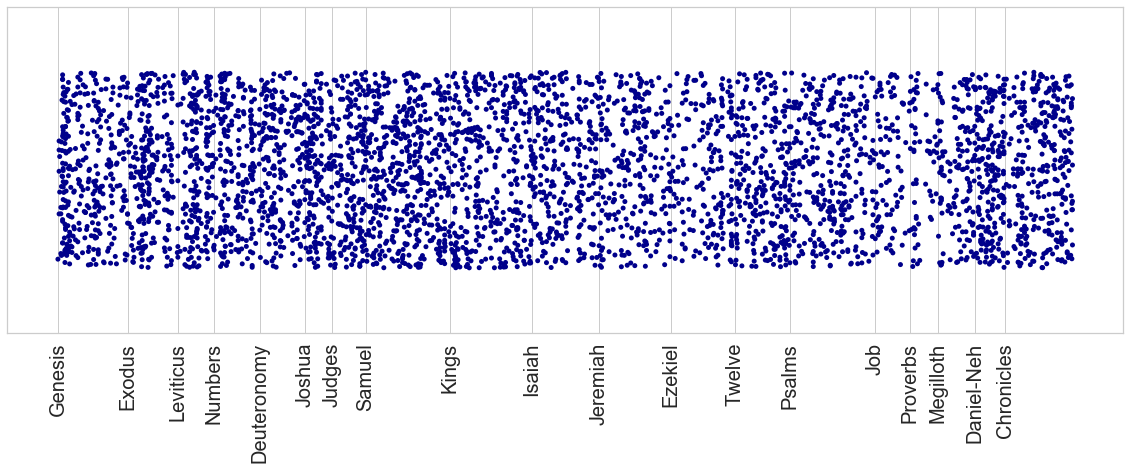

In [77]:
strip_title = 'Distribution of Time Function Constructions by segments of ~50 clauses (smaller books are grouped together)'
plt.figure(figsize=(20, 6))
sns.stripplot(x=strip_data, jitter=0.3, color='darkblue')
plt.xticks(ticks=list(bookboundaries.values()), labels=list(bookboundaries.keys()), rotation='vertical', size=20)
plt.savefig(fg_path('chapter_distribution.png'), dpi=300, bbox_inches='tight')
print(strip_title) # keep title out of savefig
plt.show()

We can see a slightly sparser population of time adverbials in some of the poetic books, especially Job-Proverbs.